# 正規分布モデルの共役事前分布によるベイズ統計

* 黒木玄
* 2022-09-03～2022-09-04
$
\newcommand\ds{\displaystyle}
\newcommand\op[1]{{\operatorname{#1}}}
\newcommand\R{{\mathbb R}}
\newcommand\var{\op{var}}
\newcommand\cov{\op{cov}}
\newcommand\ybar{{\bar y}}
\newcommand\sigmahat{{\hat\sigma}}
$

<h1>目次<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#正規分布モデルの共役事前分布とその応用" data-toc-modified-id="正規分布モデルの共役事前分布とその応用-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>正規分布モデルの共役事前分布とその応用</a></span><ul class="toc-item"><li><span><a href="#逆ガンマ正規分布" data-toc-modified-id="逆ガンマ正規分布-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>逆ガンマ正規分布</a></span></li><li><span><a href="#共役事前分布のBayes更新" data-toc-modified-id="共役事前分布のBayes更新-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>共役事前分布のBayes更新</a></span></li><li><span><a href="#μの周辺事前・事後分布および事前・事後予測分布" data-toc-modified-id="μの周辺事前・事後分布および事前・事後予測分布-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>μの周辺事前・事後分布および事前・事後予測分布</a></span></li><li><span><a href="#Jeffreys事前分布の場合" data-toc-modified-id="Jeffreys事前分布の場合-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Jeffreys事前分布の場合</a></span></li><li><span><a href="#平均と対数分散について一様な事前分布の場合" data-toc-modified-id="平均と対数分散について一様な事前分布の場合-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>平均と対数分散について一様な事前分布の場合</a></span></li><li><span><a href="#平均と対数分散について一様な事前分布の場合の結果の数値的確認" data-toc-modified-id="平均と対数分散について一様な事前分布の場合の結果の数値的確認-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>平均と対数分散について一様な事前分布の場合の結果の数値的確認</a></span></li><li><span><a href="#通常の信頼区間と予測区間との比較" data-toc-modified-id="通常の信頼区間と予測区間との比較-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>通常の信頼区間と予測区間との比較</a></span></li><li><span><a href="#データの数値から事前分布を決めた場合" data-toc-modified-id="データの数値から事前分布を決めた場合-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>データの数値から事前分布を決めた場合</a></span></li><li><span><a href="#n-=-5-ではデフォルト事前分布の場合と無情報事前分布の場合の結果が結構違う." data-toc-modified-id="n-=-5-ではデフォルト事前分布の場合と無情報事前分布の場合の結果が結構違う.-1.9"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>n = 5 ではデフォルト事前分布の場合と無情報事前分布の場合の結果が結構違う.</a></span></li><li><span><a href="#n-=-20-ではデフォルト事前分布の場合と無情報事前分布の場合の結果が近付く." data-toc-modified-id="n-=-20-ではデフォルト事前分布の場合と無情報事前分布の場合の結果が近付く.-1.10"><span class="toc-item-num">1.10&nbsp;&nbsp;</span>n = 20 ではデフォルト事前分布の場合と無情報事前分布の場合の結果が近付く.</a></span></li><li><span><a href="#n-=-20-で事前分布とデータの数値の相性が悪い場合" data-toc-modified-id="n-=-20-で事前分布とデータの数値の相性が悪い場合-1.11"><span class="toc-item-num">1.11&nbsp;&nbsp;</span>n = 20 で事前分布とデータの数値の相性が悪い場合</a></span></li></ul></li></ul></div>

In [1]:
using Distributions
using LinearAlgebra
using StatsPlots
default(fmt=:png, size=(500, 350),
    titlefontsize=10, tickfontsize=6, guidefontsize=9,
    plot_titlefontsize=10)
using SymPy
using Turing

In [2]:
# Override the Base.show definition of SymPy.jl:
# https://github.com/JuliaPy/SymPy.jl/blob/29c5bfd1d10ac53014fa7fef468bc8deccadc2fc/src/types.jl#L87-L105

@eval SymPy function Base.show(io::IO, ::MIME"text/latex", x::SymbolicObject)
    print(io, as_markdown("\\displaystyle " *
            sympy.latex(x, mode="plain", fold_short_frac=false)))
end
@eval SymPy function Base.show(io::IO, ::MIME"text/latex", x::AbstractArray{Sym})
    function toeqnarray(x::Vector{Sym})
        a = join(["\\displaystyle " *
                sympy.latex(x[i]) for i in 1:length(x)], "\\\\")
        """\\left[ \\begin{array}{r}$a\\end{array} \\right]"""
    end
    function toeqnarray(x::AbstractArray{Sym,2})
        sz = size(x)
        a = join([join("\\displaystyle " .* map(sympy.latex, x[i,:]), "&")
                for i in 1:sz[1]], "\\\\")
        "\\left[ \\begin{array}{" * repeat("r",sz[2]) * "}" * a * "\\end{array}\\right]"
    end
    print(io, as_markdown(toeqnarray(x)))
end

In [3]:
function pvalue_tdist(x̄, s², n, μ)
    t = (x̄ - μ)/√(s²/n)
    2ccdf(TDist(n-1), abs(t))
end

function pvalue_tdist(x, μ)
    x̄, s², n = mean(x), var(x), length(x)
    pvalue_tdist(x̄, s², n, μ)
end

function confint_tdist(x̄, s², n; α = 0.05)
    c = quantile(TDist(n-1), 1-α/2)
    [x̄ - c*√(s²/n), x̄ + c*√(s²/n)]
end

function confint_tdist(x; α = 0.05)
    x̄, s², n = mean(x), var(x), length(x)
    confint_tdist(x̄, s², n; α)
end

confdist_tdist(x̄, s², n) = x̄ + √(s²/n)*TDist(n-1)
confdist_tdist(x) = confdist_tdist(mean(x), var(x), length(x))

preddist_tdist(x̄, s², n) = x̄ + √(s²*(1 + 1/n))*TDist(n-1)
preddist_tdist(x) = preddist_tdist(mean(x), var(x), length(x))

preddist_tdist (generic function with 2 methods)

## 正規分布モデルの共役事前分布とその応用

### 逆ガンマ正規分布

平均 $\mu\in\R$, 分散 $v=\sigma^2\in\R_{>0}$ の正規分布の確率密度函数を次のように表す:

$$
p_\op{Normal}(y|\mu, v) =
\frac{1}{\sqrt{2\pi v}}\exp\left(-\frac{1}{2v}(y-\mu)^2\right)
\quad (y\in \R).
$$

分散パラメータ $\sigma^2$ を $v$ に書き直している理由は, $\sigma^2$ を1つの変数として扱いたいからである.

パラメータ $\kappa, \theta > 0$ の逆ガンマ分布の確率密度函数を次のように書くことにする:

$$
p_\op{InverseGamma}(v|\kappa,\theta) =
\frac{\theta^\kappa}{\Gamma(\kappa)}
v^{-\kappa-1}\exp\left(-\frac{\theta}{v}\right)
\quad (v > 0).
$$

$v$ がこの逆ガンマ分布に従う確率変数だとすると, 

$$
\begin{aligned}
&
\frac{1}{v} \sim
\op{Gamma}\left(\kappa,\, \frac{1}{\theta}\right) =
\frac{1}{2\theta}\op{Gamma}\left(\frac{2\kappa}{2},\, 2\right) =
\frac{1}{2\theta}\op{Chisq}(2\kappa),
\\ &
E[v] = \frac{\theta}{\kappa - 1}, \quad
\var(v) = \frac{E[v]^2}{\kappa - 2}.
\end{aligned}
$$

$A$ と $B$ が $\mu, v$ に関する定数因子の違いを除いて等しいことを $A\propto B$ と書くことにする.

逆ガンマ正規分布の密度函数を次のように定義する:

$$
\begin{aligned}
p_\op{InverseGammaNormal}(\mu,v|\mu_*, v_*, \kappa, \theta) &=
p_\op{Normal}(\mu|\mu_*, v_* v) p_\op{InverseGamma}(v|\kappa, \theta)
\\ &\propto
v^{-(\kappa+1/2)-1}
\exp\left(-\frac{1}{v}\left(\theta + \frac{1}{2v_*}(\mu-\mu_*)^2\right)\right).
\end{aligned}
$$

この逆ガンマ正規分布の密度函数に従う確率変数を $\mu,v$ と書くと,

$$
E[v] = \frac{\theta}{\kappa-1}, \quad
\var(v) = \frac{E[v]^2}{\kappa-2}, \quad
\cov(\mu, v) = 0, \quad
E[\mu] = \mu_*, \quad
\var(\mu) = v_* E[v].
$$

この逆ガンマ正規分布が正規分布の共役事前分布になっていることを次の節で確認する. 

### 共役事前分布のBayes更新

データの数値 $y_1,\ldots,y_n$ が与えられたとき, 正規分布モデルの尤度函数は

$$
\prod_{i=1}^n p_\op{Normal}(y_i|\mu,v) \propto
v^{-n/2}\exp\left(-\frac{1}{2v}\sum_{i=1}^n(y_i-\mu)^2\right)
$$

の形になる. このとき,

$$
\ybar = \frac{1}{n}\sum_{i=1}^n y_i, \quad
\sigmahat^2 = \frac{1}{n}\sum_{i=1}^n (y_i - \ybar)^2.
$$

とおくと, 

$$
\sum_{i=1}^n(y_i-\mu)^2 = n(\mu - \ybar)^2 + n\sigmahat^2
$$

なので, 尤度を最大化する $\mu, v$ は $\mu=\ybar$, $v=\sigmahat^2$ になることがわかる.

さらに, 次が成立することもわかる:

$$
\begin{aligned}
&
\prod_{i=1}^n p_\op{Normal}(y_i|\mu,v)\times
p_\op{InverseGammaNormal}(\mu,v|\mu_*, v_*, \kappa, \theta)
\\ &\propto
v^{-n/2}\exp\left(-\frac{n}{2v}\left((\mu-\ybar)^2 + \sigmahat^2\right)\right)\times
v^{-(\kappa+1/2)-1}
\exp\left(-\frac{1}{v}\left(\theta + \frac{1}{2v_*}(\mu-\mu_*)^2\right)\right)
\\ &=
v^{-(\kappa+n/2+1/2)-1}
\exp\left(-\frac{1}{v}\left(
\theta + \frac{n}{2}\left(\sigmahat^2 + \frac{(\ybar - \mu_*)^2}{1+nv_*}\right) +
\frac{1+nv_*}{2v_*}\left(\mu - \frac{\mu_*+nv_*\ybar}{1+nv_*}\right)^2
\right)\right).
\end{aligned}
$$

ゆえに共役事前分布から得られる事後分布のパラメータは次のようになる:

$$
\begin{alignedat}{2}
&
\tilde\kappa = \kappa + \frac{n}{2} =
\frac{n}{2}\left(1 + \frac{2\kappa}{n}\right), 
\\ &
\tilde\theta =
\theta + \frac{n}{2}\left(\sigmahat^2 + \frac{(\ybar - \mu_*)^2}{1+nv_*}\right) =
\frac{n\sigmahat^2}{2}\left(1 + \frac{2\theta}{n\sigmahat^2} + \frac{(\ybar - \mu_*)^2}{(1+nv_*)\sigmahat^2}\right),
\\ &
\tilde\mu_* = \frac{\mu_*+nv_*\ybar}{1+nv_*} =
\ybar\frac{1+\mu_*/(nv_*\ybar)}{1+1/(nv_*)}, 
\\ &
\tilde v_* = \frac{v_*}{1+nv_*} =
\frac{1}{n}\frac{1}{1+1/(nv_*)}.
\end{alignedat}
$$

In [4]:
@vars n ȳ v̂ μ v μ0 v0 κ θ

(n, ȳ, v̂, μ, v, μ0, v0, κ, θ)

In [5]:
negloglik = n/2*log(v) + n/(2v)*((μ - ȳ)^2 + v̂)

             /            2\
n*log(v)   n*\v̂ + (-ȳ + μ) /
-------- + -----------------
   2              2*v       

In [6]:
neglogpri = (κ + 1//2 + 1)*log(v) + 1/v*(θ + 1/(2v0)*(μ-μ0)^2)

                               2
                       (μ - μ0) 
                   θ + ---------
                          2*v0  
(κ + 3/2)*log(v) + -------------
                         v      

In [7]:
neglogpost = (κ + n/2 + 1//2 + 1)*log(v) +  1/v*(
    θ + n/2*(v̂ + 1/(1+n*v0)*(ȳ - μ0)^2) +
    (1 + n*v0)/(2v0)*(μ - (μ0 + n*v0*ȳ)/(1 + n*v0))^2)

                       /            2\                        2           
                       |    (ȳ - μ0) |       /    n*v0*ȳ + μ0\            
                     n*|v̂ + ---------|       |μ - -----------| *(n*v0 + 1)
                       \     n*v0 + 1/       \      n*v0 + 1 /            
                     ----------------- + θ + -----------------------------
/n       3\                  2                            2*v0            
|- + κ + -|*log(v) + -----------------------------------------------------
\2       2/                                    v                          

In [8]:
simplify(negloglik + neglogpri - neglogpost)

0

### μの周辺事前・事後分布および事前・事後予測分布

確率密度函数

$$
p(\mu|\mu_*,v_*,\kappa,\theta) =
\int_{\R_{>0}} p_\op{InverseGammaNormal}(\mu,v|\mu_*,v_*,\kappa,\theta) \,dv
$$

で定義される$\mu$ の周辺事前分布は次になる:

$$
\mu \sim
\mu_* + \sqrt{\frac{\theta}{\kappa}v_*}\;\op{TDist}(2\kappa).
$$

確率密度函数

$$
p_*(y_\op{new}|\mu_*,v_*,\kappa,\theta) =
\iint_{\R\times\R_{>0}}
p_\op{Normal}(y_\op{new}|\mu,v)
p_\op{InverseGammaNormal}(\mu,v|\mu_*,v_*,\kappa,\theta)
\,d\mu\,dv
$$

で定義される $y_\op{new}$ の事前予測分布は次になる:

$$
y_\op{new} \sim
\mu_* + \sqrt{\frac{\theta}{\kappa}(1+v_*)}\;\op{TDist}(2\kappa).
$$

パラメータをBayes更新後のパラメータ

$$
\begin{alignedat}{2}
&
\tilde\kappa = \kappa + \frac{n}{2} =
\frac{n}{2}\left(1 + \frac{2\kappa}{n}\right), 
\\ &
\tilde\theta =
\theta + \frac{n}{2}\left(\sigmahat^2 + \frac{(\ybar - \mu_*)^2}{1+nv_*}\right) =
\frac{n\sigmahat^2}{2}\left(1 + \frac{2\theta}{n\sigmahat^2} + \frac{(\ybar - \mu_*)^2}{(1+nv_*)\sigmahat^2}\right),
\\ &
\tilde\mu_* = \frac{\mu_*+nv_*\ybar}{1+nv_*} =
\ybar\frac{1+\mu_*/(nv_*\ybar)}{1+1/(nv_*)}, 
\\ &
\tilde v_* = \frac{v_*}{1+nv_*} =
\frac{1}{n}\frac{1}{1+1/(nv_*)}.
\end{alignedat}
$$

に置き換えればこれは $\mu$ の周辺事後分布および事後予測分布になる.

その事後分布を使った区間推定の幅は

* $n$ が大きいほど狭くなる.
* $\kappa$ が大きいほど狭くなる.
* $\theta$ が大きいほど広くなる.
* $|\ybar - \mu_*|/\sigmahat$ が大きいほど広くなる.
* $|\ybar - \mu_*|/\sigmahat$ が大きくても, $v_*$ がさらに大きければ狭くなる.

### Jeffreys事前分布の場合


パラメータ空間が $\{(\mu, v)=(\mu, \sigma^2)\in\R\times\R_{>0}\}$ の $2$ 次元の正規分布モデルのJeffreys事前分布 $p_\op{Jeffreys}(\mu,v)$ は

$$
p_\op{Jeffreys}(\mu,v) \propto v^{-3/2}
$$

になることが知られている. ただし, 右辺の $(\mu,v)\in\R\times\R_{>0}$ に関する積分は $\infty$ になるので, この場合のJeffreys事前分布はimproperである.

逆ガンマ正規分布の密度函数

$$
p_\op{InverseGammaNormal}(\mu,v|\mu_*, v_*, \kappa, \theta) \propto
v^{-(\kappa+1/2)-1}
\exp\left(-\frac{1}{v}\left(\theta + \frac{1}{2v_*}(\mu-\mu_*)^2\right)\right).
$$

と比較すると, Jeffreys事前分布に対応する共役事前分布のパラメータ値は形式的に次になることがわかる:

$$
\kappa \to 0, \quad
\theta \to 0, \quad
v_* \to \infty.
$$

そのとき, Bayes更新後のパラメータの公式は次のようにシンプルになる:

$$
\tilde\kappa = \frac{n}{2}, \quad
\tilde\theta = \frac{n\sigmahat^2}{2}, \quad
\tilde\mu_* = \ybar, \quad
\tilde v_* = \frac{1}{n}.
$$

さらに, 前節の公式から, $n\to\infty$ のとき, 一般のパラメータ値に関するBayes更新の結果は, $n\to\infty$ のとき漸近的にこのJeffreys事前分布の場合に一致する.

さらに, Jeffreys事前分布の場合には

$$
\frac{\tilde\theta}{\tilde\kappa} = \sigmahat^2, \quad
\tilde v_* = \frac{1}{n}, \quad
2\tilde\kappa = n.
$$

ゆえに, $\mu$ に関する周辺事後分布は

$$
\mu \sim
\ybar + \frac{\sigmahat}{\sqrt{n}}\;\op{TDist}(n)
$$

になり, 事後予測分布は次になる:

$$
y_\op{new} \sim
\ybar + \sigmahat\sqrt{1+\frac{1}{n}}\;\op{TDist}(n).
$$

### 平均と対数分散について一様な事前分布の場合

平均 $\mu$ と分数の対数 $\log v = \log\sigma^2$ に関する一様な事前分布は

$$
p_\op{flat}(\mu, v) \propto v^{-1}
$$

になる. ただし, 右辺の $(\mu,v)\in\R\times\R_{>0}$ に関する積分は $\infty$ になるので, この事前分布はimproperである.

逆ガンマ正規分布の密度函数

$$
p_\op{InverseGammaNormal}(\mu,v|\mu_*, v_*, \kappa, \theta) \propto
v^{-(\kappa+1/2)-1}
\exp\left(-\frac{1}{v}\left(\theta + \frac{1}{2v_*}(\mu-\mu_*)^2\right)\right).
$$

と比較すると, 平均と対数分散について一様な事前分布に対応する共役事前分布のパラメータ値は形式的に次になることがわかる:

$$
\kappa \to -\frac{1}{2}, \quad
\theta \to 0, \quad
v_* \to \infty.
$$

このとき, Bayes更新後のパラメータの公式は次のようになる:

$$
\tilde\kappa = \frac{n-1}{2}, \quad
\tilde\theta = \frac{n\sigmahat^2}{2}, \quad
\tilde\mu_* = \ybar, \quad
\tilde v_* = \frac{1}{n}.
$$

この場合には

$$
\frac{\tilde\theta}{\tilde\kappa} = \frac{n\sigmahat^2}{n-1} = s^2, \quad
\tilde v_* = \frac{1}{n}, \quad
2\tilde\kappa = n-1.
$$

ここで, $s^2$ はデータの数値 $y_1,\ldots,y_n$ の不偏分散

$$
s^2 = \frac{1}{n-1}\sum_{i=1}^n(y_i - \ybar)^2 =
\frac{n\sigmahat^2}{n-1} > \sigmahat^2
$$

であり, $s$ はその平方根である.

ゆえに, $\mu$ に関する周辺事後分布は

$$
\mu \sim
\ybar + \frac{s}{\sqrt{n}}\;\op{TDist}(n-1)
$$

になり, $y_\op{new}$ に関する事後予測分布は次になる:

$$
y_\op{new} \sim
\ybar + s\sqrt{1+\frac{1}{n}}\;\op{TDist}(n-1).
$$

したがって, 前節の結果と比較すると, Jeffreys事前分布の事後分布と予測分布による区間推定よりもこの場合の区間推定は少し広くなる.

### 平均と対数分散について一様な事前分布の場合の結果の数値的確認

In [9]:
@model function normaldistmodel_flat(y)
    log_v ~ Flat()
    σ² = exp(log_v)
    μ ~ Flat()
    y ~ MvNormal(fill(μ, length(y)), σ²*I)
end

normaldistmodel_flat (generic function with 2 methods)

In [10]:
μ_true, σ_true, n = 10.0, 3.0, 5
y = rand(Normal(μ_true, σ_true), n)

5-element Vector{Float64}:
 11.842482465802226
  6.259923440993461
  9.034841005068056
 10.488612932484408
  8.350869289000904

In [11]:
L = 10^5
n_threads = min(Threads.nthreads(), 10)
chn = sample(normaldistmodel_flat(y), NUTS(), MCMCThreads(), L, n_threads)

┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial 

Chains MCMC chain (100000×14×10 Array{Float64, 3}):

Iterations        = 1001:1:101000
Number of chains  = 10
Samples per chain = 100000
Wall duration     = 23.73 seconds
Compute duration  = 225.8 seconds
parameters        = log_v, μ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse           ess      rhat  ⋯
      Symbol   Float64   Float64    Float64   Float64       Float64   Float64  ⋯

       log_v    1.7758    0.8035     0.0008    0.0014   306549.2305    1.0000  ⋯
           μ    9.1948    1.3417     0.0013    0.0026   273041.8922    1.0000  ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float6

In [12]:
@show confint_tdist(y);

confint_tdist(y) = [6.558784143228545, 11.831907510111078]


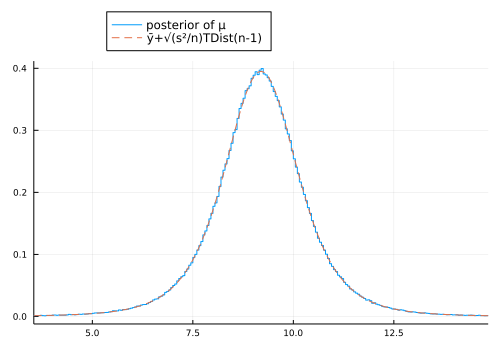

In [13]:
dist_conf = confdist_tdist(y)
plot(legend=:outertop)
stephist!(vec(chn[:μ]); norm=true, label="posterior of μ")
plot!(dist_conf; label="ȳ+√(s²/n)TDist(n-1)", ls=:dash)
plot!(xlim=quantile.(dist_conf, (0.002, 0.998)))

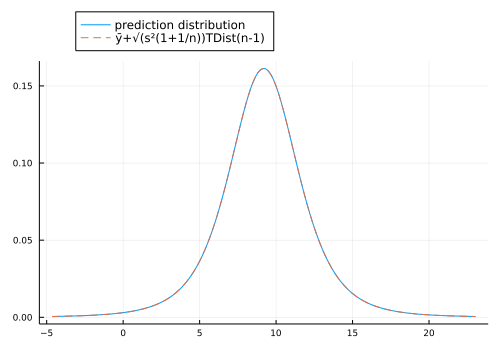

In [14]:
pdf_pred(y_new) = mean(pdf(Normal(μ, exp(0.5log_v)), y_new)
    for (μ, log_v) in zip(vec(chn[:μ]), vec(chn[:log_v])))
dist_pred = preddist_tdist(y)

plot(legend=:outertop)
plot!(pdf_pred, quantile.(dist_pred, (0.002, 0.998))...;
    label="prediction distribution")
plot!(y_new -> pdf(dist_pred, y_new);
    label="ȳ+√(s²(1+1/n))TDist(n-1)", ls=:dash)

### 通常の信頼区間と予測区間との比較

通常の $t$ 分布を使う平均の信頼区間と次の値の予測区間の構成では以下を使う:

$$
\frac{\ybar - \mu}{s\big/\!\sqrt{n}} \sim
\op{TDist}(n-1), \quad
\frac{y_\op{new} - \ybar}{s\sqrt{1+1/n}} \sim
\op{TDist}(n-1).
$$

ここで, $s^2$ はデータの数値の不偏分散であり, $s$ はその平方根である.

したがって, 前節の結果と比較すると, 通常の信頼区間と予測区間は, 平均と対数分散に関する一様事前分布に関する事後分布と予測分布を用いた区間推定に一致する.

### データの数値から事前分布を決めた場合

$a,b>0$ であると仮定する.

データの数値から共役事前分布のパラメータを次の条件によって決めたと仮定する:

$$
E[\mu] = \mu_* = \ybar, \quad
E[v] = \frac{\theta}{\kappa-1} = \sigmahat^2, \quad
\var(\mu) = v_* E[v] = a\sigmahat^2, \quad
\var(v) = \frac{E[v]^2}{\kappa-2} = b\sigmahat^4.
$$

これは次と同値である:

$$
\mu_* = \ybar, \quad
v_* = a, \quad
\kappa = 2 + \frac{1}{b}, \quad
\theta = \sigmahat^2\left(1 + \frac{1}{b}\right).
$$

これのBayes更新の結果は以下のようになる:

$$
\begin{alignedat}{2}
&
\tilde\kappa = 2 + \frac{1}{b} + \frac{n}{2} =
\frac{n}{2}\left(1 + \frac{2(2+1/b)}{n}\right)
& &
\to 2 + \frac{n}{2},
\\ &
\tilde\theta =
\sigmahat^2\left(1 + \frac{1}{b} + \frac{n}{2}\right) + \frac{n}{2}\frac{(\ybar - \ybar)^2}{1+na} =
\frac{n\sigmahat^2}{2}\left(1 + \frac{2(1+1/b))}{n}\right)
& &
\to \sigmahat^2\left(1 + \frac{n}{2}\right),
\\ &
\tilde\mu_* = \frac{\ybar+nv_*\ybar}{1+nv_*} =
\ybar
& &
\to \ybar,
\\ &
\tilde v_* = \frac{a}{1+na} =
\frac{1}{n}\frac{1}{1+1/(na)}
& &
\to \frac{1}{n}.
\end{alignedat}
$$

以上における $\to$ は $a\to\infty$, $b\to\infty$ での極限を意味する.

以上の構成のポイントは, $\mu_* = \ybar$ となっているおかげで, $\tilde\mu_*$ も $\tilde\mu_* = \ybar$ となってバイアスが消え, さらに, $\tilde\theta$ の中の $\ds\frac{n}{2}\frac{(\ybar - \mu_*)^2}{1+na}$ の項が消えて, 区間推定の幅が無用に広くならずに済むことである.

ただし, この場合には 

$$
\frac{\tilde\theta}{\tilde\kappa} =
\sigmahat^2\frac{1 + 2(1+1/b)/n}{1 + 2(2+1/b)/n} < \sigmahat^2, \quad
v_* = \frac{1}{n}\frac{1}{1+1/(na)} < \frac{1}{n}
$$

なので, 区間推定の幅はJeffreys事前分布の場合よりも少し狭くなる.

しかし, $n$ が大きければそれらの違いは小さくなる.

In [15]:
function posterior(y;
        a = 2.5, b = 2.5, n = length(y), ȳ = mean(y), σ̂² = var(y; corrected=false),
    )
    μ_star = ȳ
    v_star = a/(1 + n*a)
    κ = 2 + 1/b + n/2
    θ = σ̂²*(1 + 1/b + n/2)
    (μ_star, v_star, κ, θ)
end

postdist_μ(μ_star, v_star, κ, θ) = μ_star + √(θ/κ * v_star) * TDist(2κ)
preddist(μ_star, v_star, κ, θ) = μ_star + √(θ/κ * (1 + v_star)) * TDist(2κ)

preddist (generic function with 1 method)

### n = 5 ではデフォルト事前分布の場合と無情報事前分布の場合の結果が結構違う.

In [16]:
@model function normaldistmodel(y;
        a = 2.5, b = 2.5, ȳ = mean(y), σ̂² = var(y; corrected=false),
        μ_star = ȳ, v_star = a, κ = 2 + 1/b, θ = σ̂²*(1 + 1/b)
    )
    σ² ~ InverseGamma(κ, θ)
    μ ~ Normal(μ_star, √(v_star * σ²))
    y ~ MvNormal(fill(μ, length(y)), σ²*I)
end

normaldistmodel (generic function with 2 methods)

In [17]:
y

5-element Vector{Float64}:
 11.842482465802226
  6.259923440993461
  9.034841005068056
 10.488612932484408
  8.350869289000904

In [18]:
chn = sample(normaldistmodel(y), NUTS(), MCMCThreads(), L, n_threads)

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial

Chains MCMC chain (100000×14×10 Array{Float64, 3}):

Iterations        = 1001:1:101000
Number of chains  = 10
Samples per chain = 100000
Wall duration     = 21.81 seconds
Compute duration  = 175.57 seconds
parameters        = σ², μ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse           ess      rhat  ⋯
      Symbol   Float64   Float64    Float64   Float64       Float64   Float64  ⋯

          σ²    3.6076    2.1076     0.0021    0.0030   513714.3064    1.0000  ⋯
           μ    9.1964    0.8180     0.0008    0.0011   598792.3096    1.0000  ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

In [19]:
@show confint_tdist(y);

confint_tdist(y) = [6.558784143228545, 11.831907510111078]


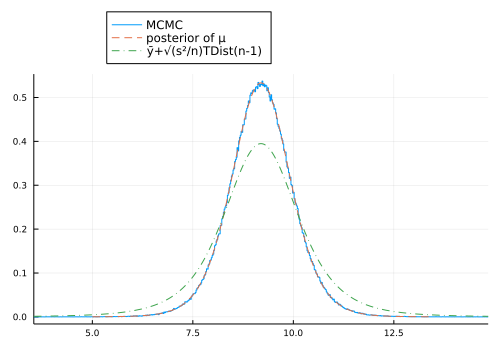

In [20]:
dist_conf = confdist_tdist(y)
dist_post = postdist_μ(posterior(y)...)
plot(legend=:outertop)
stephist!(vec(chn[:μ]); norm=true, label="MCMC")
plot!(dist_post; label="posterior of μ", ls=:dash)
plot!(dist_conf; label="ȳ+√(s²/n)TDist(n-1)", ls=:dashdot)
plot!(xlim=quantile.(dist_conf, (0.002, 0.998)))

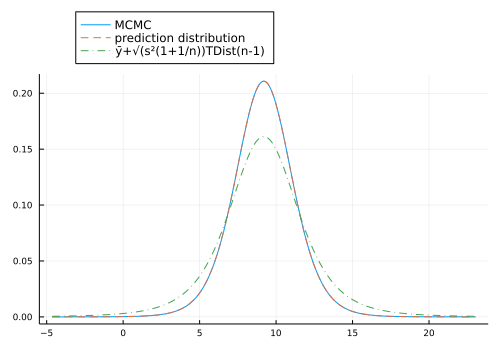

In [21]:
pdf_pred(y_new) = mean(pdf(Normal(μ, √σ²), y_new)
    for (μ, σ²) in zip(vec(chn[:μ]), vec(chn[:σ²])))
dist_pred_bayes = preddist(posterior(y)...)
dist_pred_tdist = preddist_tdist(y)
#xlim = quantile.(dist_pred_bayes, (0.002, 0.998))
xlim = quantile.(dist_pred_tdist, (0.002, 0.998))

plot(legend=:outertop)
plot!(pdf_pred, xlim...;
    label="MCMC")
plot!(dist_pred_bayes, xlim...;
    label="prediction distribution", ls=:dash)
plot!(dist_pred_tdist, xlim...;
    label="ȳ+√(s²(1+1/n))TDist(n-1)", ls=:dashdot)

### n = 20 ではデフォルト事前分布の場合と無情報事前分布の場合の結果が近付く.

In [22]:
# データの数値をかなり大きくする.
μ_true, σ_true, n = 1e4, 1e2, 20
@show dist_true = Normal(μ_true, σ_true) n
y = rand(dist_true, n);

dist_true = Normal(μ_true, σ_true) = Normal{Float64}(μ=10000.0, σ=100.0)
n = 20


In [23]:
chn = sample(normaldistmodel(y), NUTS(), MCMCThreads(), L, n_threads)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.

┌ Info: Found initial step size
│   ϵ = 4.8828125e-5
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
Sampling (10 threads): 100%|████████████████████████████| Time: 0:00:00


Chains MCMC chain (100000×14×10 Array{Float64, 3}):

Iterations        = 1001:1:101000
Number of chains  = 10
Samples per chain = 100000
Wall duration     = 17.66 seconds
Compute duration  = 151.51 seconds
parameters        = σ², μ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters         mean         std   naive_se      mcse           ess       ⋯
      Symbol      Float64     Float64    Float64   Float64       Float64   Flo ⋯

          σ²   11761.4226   3643.0566     3.6431    4.2257   759629.9461    1. ⋯
           μ   10002.1003     24.0140     0.0240    0.0249   873401.2031    1. ⋯
                                                               2 columns omitted

Quantiles
  parameters        2.5%       25.0%        50.0%        75.0%        97.5% 
      Symbol     Float64     Float64      Float64 

In [24]:
@show confint_tdist(y);

confint_tdist(y) = [9950.075345254349, 10054.199644479408]


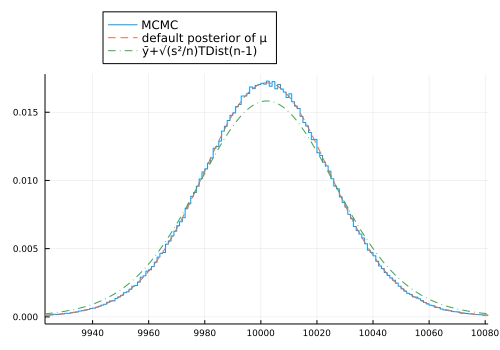

In [25]:
dist_conf = confdist_tdist(y)
dist_post = postdist_μ(posterior(y)...)
plot(legend=:outertop)
stephist!(vec(chn[:μ]); norm=true, label="MCMC")
plot!(dist_post; label="default posterior of μ", ls=:dash)
plot!(dist_conf; label="ȳ+√(s²/n)TDist(n-1)", ls=:dashdot)
plot!(xlim=quantile.(Ref(vec(chn[:μ])), (0.001, 0.999)))

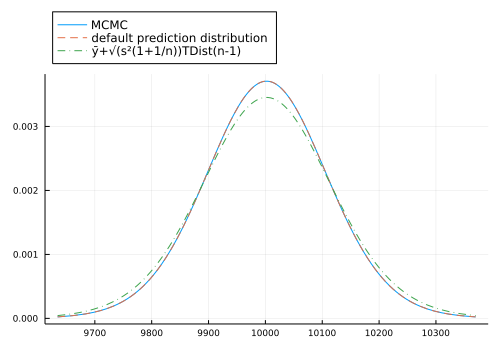

In [26]:
pdf_pred(y_new) = mean(pdf(Normal(μ, √σ²), y_new)
    for (μ, σ²) in zip(vec(chn[:μ]), vec(chn[:σ²])))
dist_pred_bayes = preddist(posterior(y)...)
dist_pred_tdist = preddist_tdist(y)
xlim = quantile.(dist_pred_bayes, (0.001, 0.999))
#xlim = quantile.(dist_pred_tdist, (0.001, 0.999))

plot(legend=:outertop)
plot!(pdf_pred, xlim...;
    label="MCMC")
plot!(dist_pred_bayes, xlim...;
    label="default prediction distribution", ls=:dash)
plot!(dist_pred_tdist, xlim...;
    label="ȳ+√(s²(1+1/n))TDist(n-1)", ls=:dashdot)

### n = 20 で事前分布とデータの数値の相性が悪い場合

In [27]:
a, b = 10.0, 10.0
μ_star, v_star, κ, θ = 0.0, a, 2 + 1/b, 1 + 1/b
@show μ_star v_star κ θ
Eμ, Ev = μ_star, θ/(κ - 1)
var_μ, var_v = v_star*Ev, Ev^2/(κ - 2)
@show Eμ Ev var_μ var_v
model = normaldistmodel(y; μ_star, v_star, κ, θ)

μ_star = 0.0
v_star = 10.0
κ = 2.1
θ = 1.1
Eμ = 0.0
Ev = 1.0
var_μ = 10.0
var_v = 9.999999999999991


DynamicPPL.Model{typeof(normaldistmodel), (:y, :a, :b, :ȳ, :σ̂², :μ_star, :v_star, :κ, :θ), (:a, :b, :ȳ, :σ̂², :μ_star, :v_star, :κ, :θ), (), Tuple{Vector{Float64}, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64}, NTuple{8, Float64}, DynamicPPL.DefaultContext}(normaldistmodel, (y = [10166.062790496948, 10008.826245713864, 10099.687439746831, 10052.316989496587, 9906.384613622007, 9971.965667388273, 10213.945709762043, 9812.776061487099, 10006.836584450682, 9966.833374320784, 10006.56265386828, 10199.270140637116, 9920.849533678655, 9904.112041614972, 9982.079189890888, 10006.20676985534, 9832.637200506008, 10070.920004305975, 9882.784935295143, 10031.691951200066], a = 2.5, b = 2.5, ȳ = 10002.137494866878, σ̂² = 11755.723252897847, μ_star = 0.0, v_star = 10.0, κ = 2.1, θ = 1.1), (a = 2.5, b = 2.5, ȳ = 10002.137494866878, σ̂² = 11755.723252897847, μ_star = 10002.137494866878, v_star = 2.5, κ = 2.4, θ = 16458.012554056986), DynamicPPL.DefaultContext())

In [28]:
chn = sample(model, NUTS(), MCMCThreads(), L, n_threads)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.

┌ Info: Found initial step size
│   ϵ = 2.44140625e-5
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 2.44140625e-5
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC D:\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
Sampling (10 threads): 100%|████████████████████████████| Time: 0:00:02


Chains MCMC chain (100000×14×10 Array{Float64, 3}):

Iterations        = 1001:1:101000
Number of chains  = 10
Samples per chain = 100000
Wall duration     = 16.24 seconds
Compute duration  = 156.81 seconds
parameters        = σ², μ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters          mean           std   naive_se       mcse           ess   ⋯
      Symbol       Float64       Float64    Float64    Float64       Float64   ⋯

          σ²   459019.7855   144892.4124   144.8924   166.8436   727782.4295   ⋯
           μ     9952.7599      151.3976     0.1514     0.1668   837843.1094   ⋯
                                                               2 columns omitted

Quantiles
  parameters          2.5%         25.0%         50.0%         75.0%         9 ⋯
      Symbol       Float64       Float64      

In [29]:
@show confint_tdist(y);

confint_tdist(y) = [9950.075345254349, 10054.199644479408]


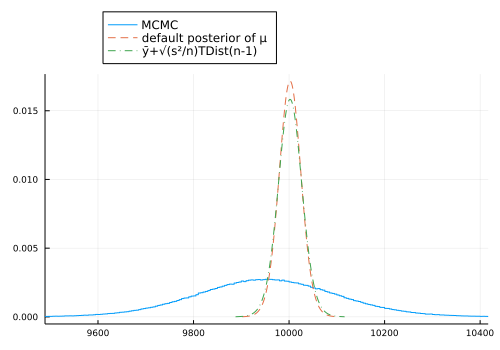

In [30]:
dist_conf = confdist_tdist(y)
dist_post = postdist_μ(posterior(y)...)
plot(legend=:outertop)
stephist!(vec(chn[:μ]); norm=true, label="MCMC")
plot!(dist_post; label="default posterior of μ", ls=:dash)
plot!(dist_conf; label="ȳ+√(s²/n)TDist(n-1)", ls=:dashdot)
plot!(xlim=quantile.(Ref(vec(chn[:μ])), (0.002, 0.998)))

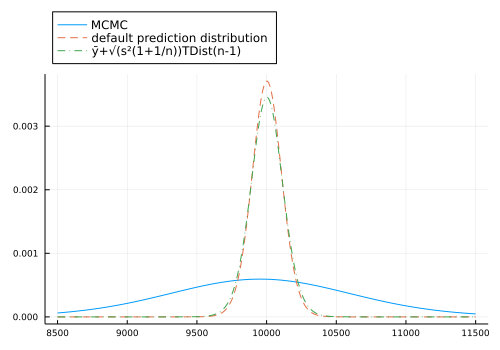

In [31]:
pdf_pred(y_new) = mean(pdf(Normal(μ, √σ²), y_new)
    for (μ, σ²) in zip(vec(chn[:μ]), vec(chn[:σ²])))
dist_pred_bayes = preddist(posterior(y)...)
dist_pred_tdist = preddist_tdist(y)
#xlim = quantile.(dist_pred_bayes, (0.002, 0.998))
#xlim = quantile.(dist_pred_tdist, (0.002, 0.998))
xlim = (8500, 11500)

plot(legend=:outertop)
plot!(pdf_pred, xlim...;
    label="MCMC")
plot!(dist_pred_bayes, xlim...;
    label="default prediction distribution", ls=:dash)
plot!(dist_pred_tdist, xlim...;
    label="ȳ+√(s²(1+1/n))TDist(n-1)", ls=:dashdot)